<a href="https://colab.research.google.com/github/jshogland/SpatialModelingTutorials/blob/main/Notebooks/kernel_pca.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Estimating kernel weights using PCA and a defined analysis window
## In this notebook we will explore the use of Raster Tools and Scikit learn functions to project predictor surfaces into orthogonal space for modeling. A few key objectives of using this approach:
- Determine and use the optimal cell weights of a convolution kernel (user defined size) that can be used to transform a given raster and its bands into a subset of surfaces that explain a user specified amount of the variation in the image data.
- Efficiently create orthogonal predictor surfaces that account for band and spatial covariation.
- Create predictor surfaces that highlight various hue and textural attributes within the data.
### The approach
- Use sampling to create training sets
- Scale input rasters to unit variance
- Perform PCA on scaled training sets that include all input cell values for the cells within a user specified analysis window
- Center scaled cell values, multiply PCA score weights by centered values, and sum values within the analysis window to perform the convolution
- Optionally, rescale PCA transformed values to a specified bit depth for storage and downstream analyses

John Hogland 12/6/20024

#### Study area for this example includes portions of the Custer Gallatin Nation Forest

Install packages

In [ ]:
!pip install mapclassify
!pip install osmnx
!pip install raster_tools
!pip install planetary-computer
!pip install pystac-client
!pip install stackstac

Import libraries

In [58]:
import numpy as np, os, geopandas as gpd, pandas as pd, osmnx as ox, pystac_client, planetary_computer, stackstac
from raster_tools import Raster, raster, general, focal, zonal
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


## Introduction
### Multispectral remotely sensed datasets are commonly used as predictor variables in many classification, regression, and clustering models. Often these data are highly correlated and covary across bands and x and y space. For compression, storage, and predictive modeling purposes it is often advantageous to project those data along shared axes of covariance to create independent transformed variables using principal component anlaysis (PCA). 
### In this example we explore the use of a PCA to project multispectral imagery along orthogonal axes derived from both band and neighboring cell values. Our procedure automates the selection of optimal kernel weights for multidimensional convolution kernels based on principal component scores and the proportion of the variation (information) explained by each component.

### The study area
#### Get the boundary data for portions of the Custer Gallatin National Forest and create a interactive location map of the study (Figure 1).

In [59]:
import folium
#use OpenStreetMaps to get the boundary of the NF
nf=ox.geocode_to_gdf('Custer Gallatin National Forest, MT, USA')

#get first polygon of the NF
nfe=nf.explode()
nf1=gpd.GeoSeries(nfe.geometry.iloc[10],crs=nf.crs)

#project to Albers equal area
nf1p=nf1.to_crs(5070)

#Visualize the nf1 and sample locations
m=nf1p.explore(color='red',style_kwds=dict(fill=False,weight=5))
folium.TileLayer(
    tiles="https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}",
    attr="Esri",
    name="Esri Imagery",
    overlay=False,
    control=True,
).add_to(m)
folium.LayerControl().add_to(m)
m

C:\Users\jshogland\AppData\Local\Temp\ipykernel_15348\4288319230.py:6: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  nfe=nf.explode()


__Figure 1.__ Interactive location map of the study area.

## Methods
### To project Landsat 8 imagery to independent component surfaces (ICSs) we will implement a multistep approach.
1. Download part of a Landsat scene for the area around the Custer Gallatin Nation Forest (Figure 1) from Planetary Computer. 
2. Create convolution PCA model using a ksize by ksize analysis window.
ksize. Apply component scores to kernel cell values within each Landsat band. 

To perform these steps, we created a series of python functions that utilize Scikit Learn and Raster Tools application programming interface (API).


### Step 1: Get Landsat 8 Imagery
Create download definitions

In [60]:
#create definition to mosaic stac data
def mosaic_stac(xr):
    return stackstac.mosaic(xr)

#create definition to extract stac data
def get_stac_data(geo,url="https://planetarycomputer.microsoft.com/api/stac/v1",name="sentinel-2-l2a",res=30,crs=5070,**kwarg):
    '''
    gets tiled data from planetary computer as a dask backed xarray that intersects the geometry of the point, line, or polygon

    geo = (polygon) geometry bounding box (WGS84)
    url = (string) base url to planetary computer https://planetarycomputer.microsoft.com/api/stac/v1
    name = (string) catelog resource
    qry =  (dictionary) of property values {'eo:cloud_cover':{'lt':1}}
    res = (tuple of numbers) output resolution (x,y)
    crs = (int) output crs
    dt = (string) data time intervale e.g., one month: 2023-06, range: 2023-06-02/2023-06-17
    limit = (int) max number of items to return

    returns (xarray data array and stac item catalog)
    '''
    catalog = pystac_client.Client.open(url, modifier=planetary_computer.sign_inplace)
    srch = catalog.search(collections=name, intersects=geo, **kwarg)
    ic = srch.item_collection()
    if(len(ic.items)>0):
        xra = stackstac.stack(ic,resolution=res,epsg=crs)
        xra = mosaic_stac(xra)
    else:
        xra=None

    return xra,ic


Download the data and create a raster object

In [61]:
#get stac data landsat data
if(not os.path.exists('ls82016.tif')):
    xmin,ymin,xmax,ymax=nf1p.buffer(200).total_bounds
    ls30, ic =get_stac_data(nf1.geometry[0],"https://planetarycomputer.microsoft.com/api/stac/v1",name="landsat-c2-l2",res=30,crs=5070,datetime='2016-06-15/2016-06-30',query={'eo:cloud_cover':{'lt':10},'platform':{'eq':'landsat-8'}},limit=1000)
    ls30s=Raster(ls30.sel(band=['red', 'green', 'blue','nir08', 'lwir11','swir16', 'swir22'],x=slice(xmin,xmax),y=slice(ymax,ymin)))
    ls30s=ls30s.save('ls82016.tif')

ls30s=Raster('ls82016.tif')

### Visualize the boundary and  imagery (Figure 2)

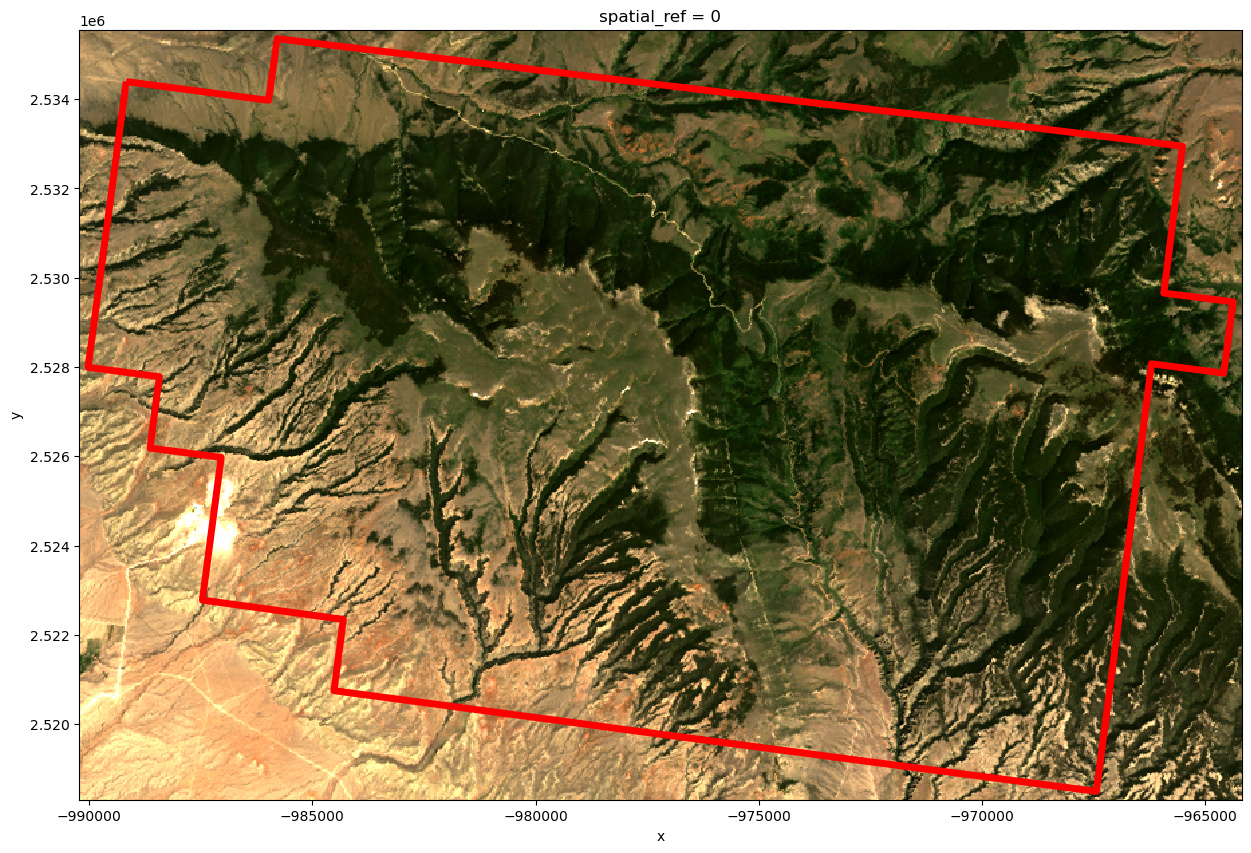

In [62]:
p=nf1p.plot(edgecolor='red',facecolor='none',figsize=(15,10),linewidth=5)
p=ls30s.get_bands([1,2,3]).xdata.plot.imshow(ax=p,robust=True)


__Figure 2.__ Overlay of Landsat 8 image subset (RGB bands) and the study area boundary outline in red.

### Step 2: Create convolution PCA model
Create definitions to sample the data, generate weights, and perform convolution analysis.

In [63]:
from sklearn.preprocessing import MinMaxScaler
import numba as nb
import xarray as xr

@nb.jit(nopython=True, nogil=True, parallel=False)
def _conv_pca(x,cmp_, m_, size):
    '''
    Performs the convolution given a array, component scores, means, and kernel size using dask's map_overlap function
    x=(numpy array) of data
    cmp_= (numpy array) component scores from sklearn PCA procedure
    m_= (numpy array) mean values from sklearn PCA procedure
    size= (int) width of the kernel

    returns a numpy array of correct shape for PCA transformation
    '''
    bnd,rws,clms=x.shape
    hs=int(size/2)
    outarr=np.empty((cmp_.shape[0],rws,clms))
    for ri in range(hs,rws-hs):
        sr=ri-hs
        for ci in range(hs,clms-hs):
            sc=ci-hs
            vls=x[:,sr:sr+size,sc:sc+size].flatten()
            for b in range(cmp_.shape[0]):
                vls2=((vls-m_)*cmp_[b,:]).sum() #removed the centering piece in standard scaler it is done here
                outarr[b,ri,ci]=vls2

    return outarr


@nb.jit(nopython=True, nogil=True, parallel=False)
def _expand_pnts_for_kernel(isys,isxs,wsize):
    '''
    Extracts values for kernel cells. Cells indices falling on the boundary of the image are moved in one index value.
    isys=array of row index locations
    isxs=array of column index locations
    wsize=width of the kernel
    
    returns two new lists of index values kernel cell locations that can be used to extract coordinate from an xarray data array
    '''
    hw=int(wsize/2)
    isys2=np.zeros(isys.shape[0]*wsize*wsize,dtype='int32')
    isxs2=np.zeros(isxs.shape[0]*wsize*wsize,dtype='int32')
    cnt=0
    for r in range(isys.shape[0]):
        rvl=isys[r]
        cvl=isxs[r]
        rvlm=rvl-hw
        for r2 in range(wsize):
            nr=rvlm+r2
            cvlm=cvl-hw
            for c2 in range(wsize):
                nc=cvlm+c2
                isys2[cnt]=nr
                isxs2[cnt]=nc
                cnt+=1

    return isys2,isxs2


def _sys_sample_image(rs,p,wsize=1):
    '''
    Creates a systematic sample of an image given a percent of cells sampled.
    rs = Raster object to be sampled
    p = percent of pixels to sample
    wsize=(int) width of a square kernel in cells if using convolution type analyses

    returns a 2d array of cell values rows=point centroid columns= band values
    if using kernels columns correspond to kernel cell values for each point
    '''
    bnds,rws,clms=rs.shape
    psq=np.sqrt(p)
    sr=int(rws/(rws*psq))
    sc=int(clms/(clms*psq))
    rstr=int(np.random.rand()*sr)
    rstc=int(np.random.rand()*sc)

    isys=np.arange(rstr+wsize,rws-wsize,sr)
    isxs=np.arange(rstc+wsize,clms-wsize,sc)
    rws=isys.shape[0]
    clms=isxs.shape[0]
    
    isxs,isys=np.meshgrid(isxs,isys)
    isxs=isxs.flatten()
    isys=isys.flatten()

    if(wsize>1):
        isys,isxs=_expand_pnts_for_kernel(isys,isxs,wsize)

    sel=rs.xdata.isel(x=xr.DataArray(isxs,dims='loc'),y=xr.DataArray(isys,dims='loc'))
    vls=sel.values.reshape((sel.shape[0],rws*clms,wsize*wsize))
    vls=np.moveaxis(vls,1,0).reshape(rws*clms,sel.shape[0]*wsize*wsize)

    df=pd.DataFrame(vls)
    vls=(df[df!=rs.null_value]).dropna().values

    return vls

def conv_pca(rs,prc=0.9,smp=0.01,ksize=0,output_bit_depth=None):
    '''
    determines convolution kernel weights for an optimal raster projection and returns a transformed raster
    using those weights. Weights are derived from a PCA analysis of each kernel cell value. Kernel cell
    values are extracted for each band in the rs stack.

    rs=(Raster) input raster object
    wsize=(int) window diameter for a square kernel measured in cells
    prc=(float) the proportion of variation in the data kept in the final raster dataset (0-1)
    smp=(float) the proportion of data used to build the transformation (training data - systematic random sample of location)
    ksize=(int) kernel width to use measured in cells
    output_bit_depths=(int) optional parameter used to scale the analysis outputs to a specified bit depth (e.g., 8,16,32).
    By default (None) output values will not be scaled

    returns a projected raster object and the pca object
    '''
    #scale values using a sample
    vls=_sys_sample_image(rs,p=smp)
    ss=StandardScaler(with_mean=False)
    ss.fit(vls)

    #apply the scaling to the input raster
    ss_mdl = general.ModelPredictAdaptor(ss,'transform')
    nch=(rs.nbands,*rs.xdata.chunks[1:])
    sc_pred_rs=rs.model_predict(ss_mdl,rs.nbands).chunk(nch)

    #perform pca using a sample of the scaled raster values
    vls2=_sys_sample_image(sc_pred_rs,p=smp,wsize=ksize)
    
    pca=PCA()
    pca.fit(vls2)
    #determine number of components to use
    ev=pca.explained_variance_ratio_
    sev=0
    for i in range(ev.shape[0]):
        e=ev[i]
        sev+=e
        if sev>prc:
            break
    kc=i+1 #add one to address 0 start

    #extract component scores for _conv_pca method
    kdf=pca.components_[0:kc,:] #scores,component (rows have weightings)
    hw=int(ksize/2)

    nch=sc_pred_rs.data.chunks
    och=list(nch)
    och[0]=(kc,)
    och[1]=tuple(np.array(och[1])+hw*2)
    och[2]=tuple(np.array(och[2])+hw*2)

    #apply _conv_pca to map_overlap function
    darr=sc_pred_rs.data.map_overlap(
        _conv_pca,
        depth={0: 0, 1: hw, 2: hw},
        chunks=och,
        boundary=np.nan,
        dtype='f8',
        meta=np.array((),dtype='f8'),
        cmp_=kdf,
        m_=pca.mean_,
        size=ksize
    )
    #convert dask array back to a raster
    cmp_rs=raster.data_to_raster(darr,x=sc_pred_rs.x,y=sc_pred_rs.y,affine=sc_pred_rs.affine,crs=sc_pred_rs.crs,nv=sc_pred_rs.null_value).chunk((1,*darr.chunks[1:]))

    #scale projected raster to bit depth if specified
    #mmsc=''
    if(not output_bit_depth is None):
        pcasvls=pca.transform(vls2)[:,0:kc]
        l=pcasvls.min()
        m=pcasvls.max()
        cmp_rs=((cmp_rs-l)/(m-l)*(2**output_bit_depth-1))
        cmp_rs=(cmp_rs.where(cmp_rs > 0,0).where(cmp_rs < 2**output_bit_depth,(2**output_bit_depth-1))).astype('int64')
    

        # mmsc=MinMaxScaler()
        # mmsc.fit(pcasvls)
        # mmsc_mdl=general.ModelPredictAdaptor(mmsc,'transform')
        # cmp_rs=(cmp_rs.model_predict(mmsc_mdl,cmp_rs.nbands)*(2**output_bit_depth-1)).astype('uint'+str(output_bit_depth))

    return cmp_rs,pca



### Step 3: Apply the convolution PCA

In [64]:
#perform the pca convolution process on the landsat image; kernel size 5 by 5, output bit depth 16.
# This can be any size kernel. I have tried up to a 15 by 15.
ksize=5
conv_rs,pca=conv_pca(ls30s,prc=0.95,smp=0.1,ksize=ksize,output_bit_depth=16)

## Results
### Using our described approach, we accounted for 95% of the variation within the image using the first 10 principal components (Figure 3). Component convolution kernel weights (Display 1) highlight the linear relationships among both Landsat image bands and neighboring kernel cell values. For a random systematic sample of approximately 10% of the first 3 component values, unique clusters of information with varying trends appear in component space (Figure 4). 
### To transform our Landsat 8 image into 10 independent component surfaces (ICSs; Figure 5) required processing 70, 5 by 5 convolution kernels. T

### - % variation explained in each band (component) of the transformed image (Figure 3).
#### The number of bands correspond to the number of components that account for 95% of the variation in the 5 by 5 convolved image. Note that most of the variation/information in the data is explained in the first 3 components

Total % variance explained in components = 0.9512241200886593


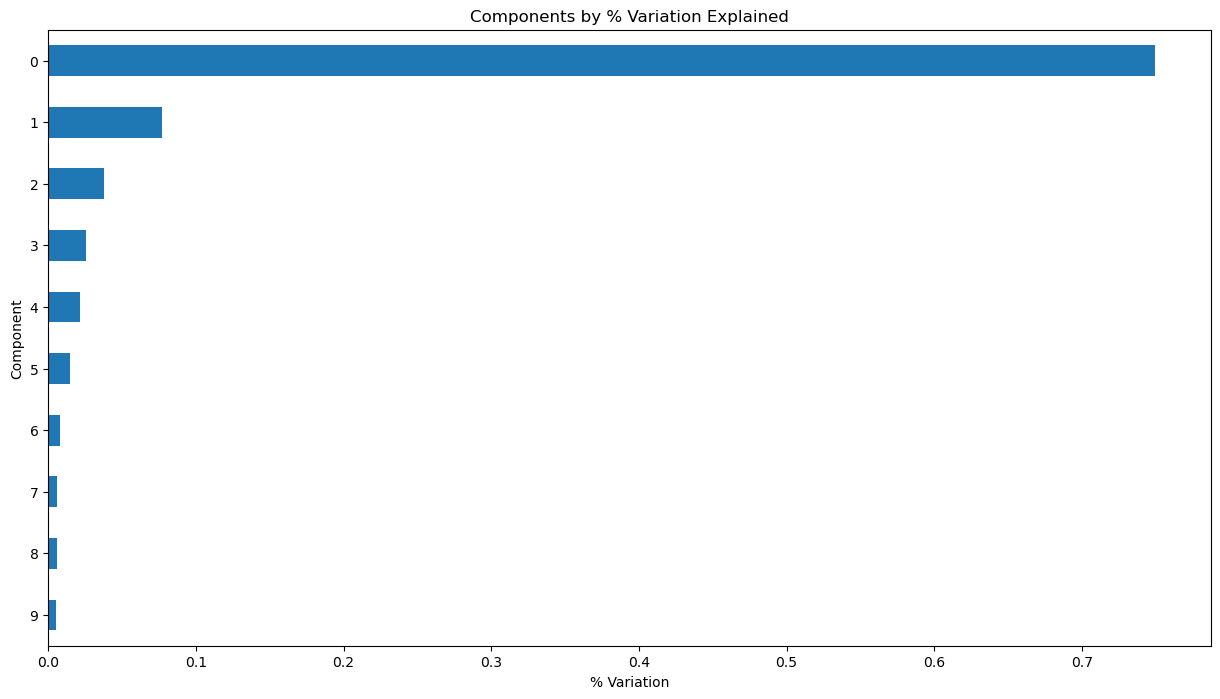

In [65]:
var_exp=pd.DataFrame(pca.explained_variance_ratio_[:conv_rs.nbands])
print('Total % variance explained in components =',var_exp.sum().values[0])
p=var_exp.plot(kind='barh',title='Components by % Variation Explained', xlabel='% Variation', ylabel='Component', figsize=(15,8),legend=False).invert_yaxis()
p

__Figure 3.__ Proportion of variation explained in each principal component. 

### - Look at the kernel weights for each selected component (Display 1).
#### Each component is made of the summation of 7 convolution kernels with the following weights. Convolution weights are applied to the centered and scaled input surface values of each band within the specified kernel of the input raster surface (ls30s in our example).

In [66]:
kw=pca.components_[0:conv_rs.nbands,:]
for k in range(kw.shape[0]):
    krs=kw[k].reshape((ls30s.nbands,ksize,ksize))
    print('\nWeights for component',k)
    for b in ls30s.band:
        print('Band =',b)
        print(pd.DataFrame(krs[b-1]))


Weights for component 0
Band = 1
          0         1         2         3         4
0  0.076783  0.078587  0.079435  0.079447  0.078702
1  0.079083  0.080764  0.081402  0.081126  0.079533
2  0.080217  0.081647  0.082059  0.081195  0.079253
3  0.080420  0.081561  0.081337  0.080133  0.078242
4  0.079478  0.079801  0.079181  0.078027  0.075908
Band = 2
          0         1         2         3         4
0  0.075872  0.077836  0.078779  0.078864  0.078125
1  0.078386  0.080236  0.080966  0.080735  0.079093
2  0.079675  0.081249  0.081781  0.080872  0.078844
3  0.080021  0.081289  0.081106  0.079878  0.077890
4  0.079094  0.079503  0.078897  0.077696  0.075446
Band = 3
          0         1         2         3         4
0  0.076157  0.077971  0.078914  0.078917  0.078111
1  0.078494  0.080177  0.080895  0.080638  0.078967
2  0.079644  0.081125  0.081634  0.080703  0.078724
3  0.079923  0.081080  0.080921  0.079739  0.077759
4  0.078946  0.079270  0.078736  0.077590  0.075372
Band = 4
   

__Display 1.__ Kernel weights for each component of the PCA convolution.

### - Look at a 3d plot of the first 3 components for systematic random locations using 10% of the data. (Figure 4)

In [67]:
import plotly.express as px
#get a sample of the PCA convolution raster values
vls=_sys_sample_image(conv_rs,0.1,1) 
df=pd.DataFrame(vls)
print('n =', df.shape[0])
fig = px.scatter_3d(df, x=0, y=1, z=2
              ,width=1500,height=800)

fig.show()


n = 55199


__Figure 4.__ A 3 dimensional representation of the first 3 principal components scores values for ~10% of the cell locations within the Landsat 8 image. 

### - Visualize the PCA convolution raster surfaces (Figure 5)

In [68]:
conv_rs.load()

<raster_tools.Raster (crs='EPSG:5070', masked=True)>
<xarray.DataArray 'raster' (band: 10, y: 575, x: 868)> Size: 40MB
dask.array<xarray-raster, shape=(10, 575, 868), dtype=int64, chunksize=(1, 575, 868), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 5kB 2.536e+06 2.536e+06 ... 2.518e+06 2.518e+06
  * x            (x) float64 7kB -9.902e+05 -9.902e+05 ... -9.642e+05 -9.642e+05
  * band         (band) int32 40B 1 2 3 4 5 6 7 8 9 10
    spatial_ref  int32 4B 0
Attributes:
    _FillValue:  -999999.0

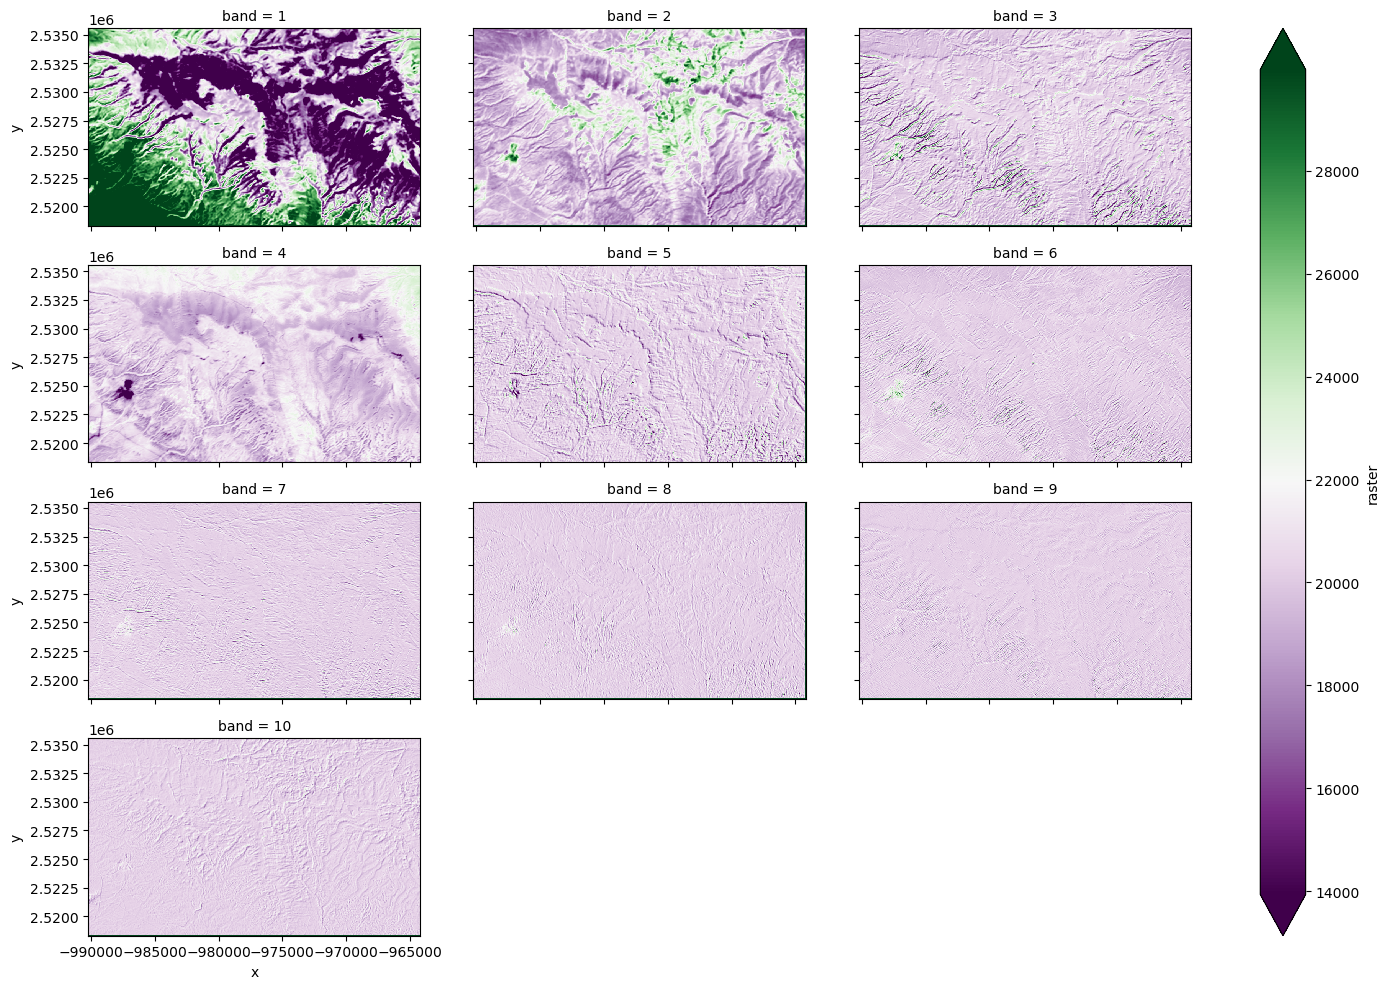

In [69]:
conv_rs.plot(x='x',y='y',col='band',col_wrap=3,figsize=(15,conv_rs.nbands),robust=True,cmap='PRGn')

__Figure 5.__ Independent component surfaces (ICSs) derived from a principal component analysis of values taken from a systematic sample of cell locations within a subset of a Landsat scene for a kernel size of five by five cells. The first eleven ICSs account for a more than 95% of the variance within the data.    

## Discussion
### In this notebook we have demonstrated how to use sampling, analysis windows, and PCA to project multi-band raster data into independent component space (Figure 4) that highlights various orthogonal aspects of the input data while simultaneously reducing the dimensionality of the data. The results of our analysis emphasize both hue and textural aspects of the data within each principal components. While kernel cell weights provide unique insights into the linear relationships among image bands and neighbor cell values, when combined with Raster Tools processing architecture they can be used to produce ICSs (Figure 5) that spatially emphasize independent hue and textural aspects of the input data.                   

## Conclusion
### The described approach is quick and mathematically determines kernel weights such that each band in the convolved output image is independent of the other band values. Moreover, the process removes all redundant information across bands and within kernel cell values, which is also desirable. These surfaces should make for effective predictor variables and\or should make it easy to spread and balance a sample across all the hue and textural information within a defined analysis window, for a given raster dataset.    
 

## Evaluate pca convolution predictors against the common texture for a 5 by 5 window

### Get Tree Canopy Cover and NLCD land cover for 2016 from MLRC website

In [70]:
import numpy as np, os, geopandas as gpd, pandas as pd, osmnx as ox, pystac_client, planetary_computer, stackstac
from raster_tools import Raster, raster, general, focal, zonal
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pygeohydro as gh

In [71]:
outpath_lulc="lulc.tif"
outpath_tcc="tcc.tif"

if(not os.path.exists(outpath_lulc)):
    bbox=nf1.envelope.buffer(0.001)

    ds2016=gh.nlcd_bygeom(bbox,years={'cover':[2016],'canopy':[2016]},ssl=False)
    lulc=Raster(ds2016[0].cover_2016).reproject(ls30s.geobox)
    tcc=Raster(ds2016[0].canopy_2016).reproject(ls30s.geobox)
    lulc.save(outpath_lulc)
    tcc.save(outpath_tcc)

lulc=Raster(outpath_lulc)
tcc=Raster(outpath_tcc)


### GLCM
- Create mean and standard deviation, GLCM texture surfaces (contrast, correlation; horizontal and vertical), and mean and standard deviation for edge convolution ([[0,1,0],[1,-4,1],[0,1,0]]) surfaces for the first 2 components
- Create pca_convolution for the first two components
- Create Random forest models and compare model results

#### Create GLCM functions

In [72]:
#GLCM
@nb.jit(nopython=True, nogil=True, parallel=False)
def _get_vl(img,glcm,rstart,rws,cstart,clms,roff,coff,n,levels):
    ovl=0
    if(glcm=='contrast'):
        ovl=_get_contrast(img,rstart,rws,cstart,clms,roff,coff,n)
    elif(glcm=='dissimilarity'):
        ovl=_get_dissimilarity(img,rstart,rws,cstart,clms,roff,coff,n)
    elif(glcm=='homogeneity'):
        ovl=_get_homogeneity(img,rstart,rws,cstart,clms,roff,coff,n)
    elif(glcm=='ASM'):
        ovl=_get_asm(img,rstart,rws,cstart,clms,roff,coff,n,levels)
    elif(glcm=='energy'):
        ovl=_get_energy(img,rstart,rws,cstart,clms,roff,coff,n,levels)
    elif(glcm=='entropy'):
        ovl=_get_entropy(img,rstart,rws,cstart,clms,roff,coff,n,levels)
    elif(glcm=='correlation'):
        ovl=_get_correlation(img,rstart,rws,cstart,clms,roff,coff,n)
    elif(glcm=='variance'):
        ovl=_get_variance(img,rstart,rws,cstart,clms,roff,coff,n)
    elif(glcm=='std'):
        ovl=_get_std(img,rstart,rws,cstart,clms,roff,coff,n)
    else:
        ovl=_get_mean(img,rstart,rws,cstart,clms,roff,coff,n)
    return ovl

@nb.jit(nopython=True, nogil=True, parallel=False)
def _get_contrast(img,rstart,rws,cstart,clms,roff,coff,n):
    s=0
    for r in range(rstart,rws):
        for c in range(cstart,clms):
            v1=img[r,c]
            v2=img[r+roff,c+coff]
            dif=v1-v2
            vl= dif*dif*2
            s+=vl
    return s/n

@nb.jit(nopython=True, nogil=True, parallel=False)
def _get_mean(img,rstart,rws,cstart,clms,roff,coff,n):
    s=0
    for r in range(rstart,rws):
        for c in range(cstart,clms):
            v1=img[r,c]
            v2=img[r+roff,c+coff]
            vl=v1+v2
            s+=vl
    return s/n

@nb.jit(nopython=True, nogil=True, parallel=False)
def _get_dissimilarity(img,rstart,rws,cstart,clms,roff,coff,n):
    s=0
    for r in range(rstart,rws):
        for c in range(cstart,clms):
            v1=img[r,c]
            v2=img[r+roff,c+coff]
            vl=np.abs(v1-v2)*2
            s+=vl
    return s/n

@nb.jit(nopython=True, nogil=True, parallel=False)
def _get_homogeneity(img,rstart,rws,cstart,clms,roff,coff,n):
    s=0
    for r in range(rstart,rws):
        for c in range(cstart,clms):
            v1=img[r,c]
            v2=img[r+roff,c+coff]
            dif=v1-v2
            vl= 2/(1+(dif*dif))
            s+=vl
    return s/n

@nb.jit(nopython=True, nogil=True,  parallel=False)
def _get_array(img,rstart,rws,cstart,clms,roff,coff,levels):
    #dic={}
    p_arr=np.zeros((levels,levels))
    for r in range(rstart,rws):
        for c in range(cstart,clms):
            v1=int(img[r,c])
            v2=int(img[r+roff,c+coff])
            p_arr[v1,v2]+=1
            p_arr[v2,v1]+=1
     
    return p_arr

@nb.jit(nopython=True, nogil=True,  parallel=False)
def _get_entropy(img,rstart,rws,cstart,clms,roff,coff,n,levels):
    p = _get_array(img,rstart,rws,cstart,clms,roff,coff,levels)
    rws2,clms2=p.shape
    s=0
    for r in range(rws2):
        for c in range(clms2):
            v=p[r,c]
            vl=v/n+0.00000000001
            s+=-1*vl*np.log(vl)
    
    return s

@nb.jit(nopython=True, nogil=True,  parallel=False)
def _get_asm(img,rstart,rws,cstart,clms,roff,coff,n,levels):
    p = _get_array(img,rstart,rws,cstart,clms,roff,coff,levels)
    rws2,clms2=p.shape
    s=0
    for r in range(rws2):
        for c in range(clms2):
            v=p[r,c]
            vl=v/n
            s+=vl*vl

    return s

@nb.jit(nopython=True, nogil=True,  parallel=False)
def _get_energy(img,rstart,rws,cstart,clms,roff,coff,n,levels):
    return _get_asm(img,rstart,rws,cstart,clms,roff,coff,n,levels)**0.5

@nb.jit(nopython=True, nogil=True,  parallel=False)
def _get_variance(img,rstart,rws,cstart,clms,roff,coff,n):
    s=0
    s2=0
    for r in range(rstart,rws):
        for c in range(cstart,clms):
            v1=img[r,c]
            v2=img[r+roff,c+coff]
            s+=v1+v2
            s2+=v1**2+v2**2
    return (s2-((s**2)/n))/n

@nb.jit(nopython=True, nogil=True,  parallel=False)
def _get_std(img,rstart,rws,cstart,clms,roff,coff,n):
    return _get_variance(img,rstart,rws,cstart,clms,roff,coff,n)**0.5

@nb.jit(nopython=True, nogil=True,  parallel=False)
def _get_correlation(img,rstart,rws,cstart,clms,roff,coff,n):
    sxy=0
    sx=0
    sx2=0
    
    for r in range(rstart,rws):
        for c in range(cstart,clms):
            v1=img[r,c]
            v2=img[r+roff,c+coff]
            sx+=v1+v2
            sx2+=v1**2+v2**2
            sxy+=v1*v2
            
    
    num=n*sxy*2-sx*sx
    den=((n*sx2-sx**2)*(n*sx2-sx**2))**0.5
    
    return num/den
    

@nb.jit(nopython=True, nogil=True,  parallel=False)
def _get_n(rws,clms,dist,dir):
    n=1
    if(dir==0):
        n=(rws-dist)*2*clms
    elif(dir==2):
        n=2*rws*(clms-dist)
    else:
        n=(rws-dist)*(clms-dist)*2
    return n

@nb.jit(nopython=True, nogil=True,  parallel=False)
def _get_glcm(img,glcms,dists,dirs,levels):
    out_arr=np.zeros((len(glcms),len(dists),len(dirs)))
    gcnt=0
    for glcm in glcms:
        dcnt=0
        for dist in dists:
            drcnt=0
            for dir in dirs:
                rws,clms=img.shape
                n=_get_n(rws,clms,dist=dist,dir=dir)
                # s=0
                coff=0
                roff=0
                rstart=0
                cstart=0
                if(dir==0):
                    coff=dist
                    clms=clms-coff
                elif(dir==1):
                    coff=dist
                    roff=dist
                    clms=clms-coff
                    rws=rws-roff
                elif(dir==2):
                    roff=dist
                    rws=rws-roff
                else:
                    roff=(dist)
                    coff=(-1*dist)
                    cstart=dist
                    rws=rws-roff
                out_arr[gcnt,dcnt,drcnt]=_get_vl(img,glcm,rstart,rws,cstart,clms,roff,coff,n,levels)
                drcnt+=1
            dcnt+=1
        gcnt+=1
    return out_arr    

@nb.jit(nopython=True, nogil=True,  parallel=False)
def _glcm(X,glcms,dists,dirs,wsize,levels):
    ''' 
    Creates GLCM surfaces for a given array. Used with dask's map_overlap function.
    
    X = (array) numpy array
    glcms = (list of glcm names) ['contrast', 'dissimilarity', 'homogeneity', 'ASM', 'energy', 'correlation', 'mean', 'variance', 'std', 'entropy']
    dists = (list of cell offsets) [1,2,3...]
    dirs = (list of offset directions) [0,1,2,3] 0=horzontal, 1=diagonal 1, 2=vertical, 3=diagonal 2
    wsize = (int) window width
    returns a 3d array with dimensions equal to the length of bnds*glcms*dists*dirs,rows,columns of the original image and parameters
    '''
    bnd,rws,clms=X.shape
    hw=int(wsize/2)
    lg=len(glcms)
    ld=len(dists)
    ldr=len(dirs)
    outarr=np.zeros((bnd*lg*ld*ldr,rws,clms))
    for b in range(bnd):
        bndst=b*lg*ld*ldr
        bndend=bndst+lg*ld*ldr
        for r in range(0,rws-wsize):
            nr=r+hw
            for c in range(0,clms-wsize):
                nc=c+hw
                img= X[b,r:r+wsize,c:c+wsize]
                vls=_get_glcm(img,glcms,dists,dirs,levels)
                outarr[bndst:bndend,nr,nc]=vls.flatten()
    return outarr

def glcm_wd(rs,glcm='contrast',dist=1,dir=0,wsize=3,cat=8):
    ''' 
    Creates GLCM Raster for a specified GLCM and window size.
    
    rs = (Raster) input raster
    glcm = (string) glcm names ['contrast', 'dissimilarity', 'homogeneity', 'ASM', 'energy', 'correlation', 'mean', 'variance', 'std', 'entropy']
    dist = (int) cell offsets) 1,2,3, or ...
    dir = (int) offset directions) 0,1,2, or 3 0=horzontal, 1=diagonal 1, 2=vertical, 3=diagonal 2
    wsize = (int) window width
    cat = (int) optional values for ASM, energy, and entropy GLCM. For these GLCM metrics, raster cell values cannot be greater than the number of levels-1 
    
    returns a mutiband Raster with dimensions equal to the length of bnds*glcms*dists*dirs,rows,columns of the original image and parameters
    '''
    hw=int(wsize/2)
    #use map overlap function to retrieve kernel cell values
    darr = rs.data.map_overlap(
        _glcm,
        depth={0: 0, 1: hw, 2: hw},
        trim=True,
        boundary=0,
        dtype='f8',
        meta=np.array((),dtype='f8'),
        glcms=[glcm],
        dists=[dist],
        dirs=[dir],
        wsize=wsize,
        levels=cat,
    )
    out_rs=raster.data_to_raster(darr,mask=rs.mask,x=rs.x,y=rs.y,affine=rs.affine,crs=rs.crs)
    return out_rs    


#### Create predictors for common texture metrics (5 by 5 window) and pca_conv

In [73]:
outpath_com='com_pred.tif'
outpath_pca='pca_pred.tif'
ksize=5
red_nir = ls30s.get_bands([1,4])

if(not os.path.exists(outpath_com)):
    fm=focal.focal(red_nir,'mean',ksize,ksize)
    fs=focal.focal(red_nir,'std',ksize,ksize)
    edg=focal.convolve(red_nir,[[0,1,0],[1,-4,1],[0,1,0]])
    em=focal.focal(edg,'mean',ksize,ksize)
    es=focal.focal(edg,'std',ksize,ksize)
    gcont_h=glcm_wd(red_nir,'contrast',1,0,wsize=ksize)
    gcont_v=glcm_wd(red_nir,'contrast',1,2,wsize=ksize)
    gcorr_h=glcm_wd(red_nir,'correlation',1,0,wsize=ksize)
    gcorr_v=glcm_wd(red_nir,'correlation',1,2,wsize=ksize)

    t_pred_rs=general.band_concat([fm,fs,gcont_h,gcont_v,gcorr_h,gcorr_v,em,es])
    

    t_pred_rs.save(outpath_com)
    

t_pred_rs=Raster(outpath_com)

if(not os.path.exists(outpath_pca)):
    pca_pred_rs,pca=conv_pca(red_nir,0.95,0.1,ksize)
    pca_pred_rs.save(outpath_pca)

pca_pred_rs=Raster(outpath_pca)


### Create Random Forest Models 
#### Perform 100 iteration of the analysis using a sample size of 150 and look at accuracy 

In [74]:
def get_tbl(xs,ys,rs):
    sel=rs.xdata.sel(x=xr.DataArray(xs,dims='loc'),y=xr.DataArray(ys,dims='loc'),method="nearest")
    vls=sel.values
    vls=np.moveaxis(vls,1,0)
    df=pd.DataFrame(vls)
    vls=(df[df!=rs.null_value]).dropna().values
    return vls

def get_smp(bndry,rs,ss=150,ksize=5):
    pbnd=bndry.to_crs(rs.crs)
    bnd=pbnd.unary_union
    area=bnd.area
    sk=int(((area/ss) ** 0.5)/ls30s.resolution[0])
    x=ls30s.x[ksize:-ksize]
    y=ls30s.y[ksize:-ksize]
    xst=np.random.randint(sk)
    yst=np.random.randint(sk)
    xs=x[xst:x.shape[0]:sk]
    ys=y[yst:y.shape[0]:sk]
    xs,ys=np.meshgrid(xs,ys)
    xs=xs.flatten()
    ys=ys.flatten()
    pnts=gpd.points_from_xy(xs,ys)
    pnts=pnts[pnts.intersects(bnd)]

    return pnts

In [75]:
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier, RandomForestClassifier, RandomForestRegressor

ss=1500
tss=int(ss*0.75)
vss=int(ss-tss)

iter=100
ac1=[]
ac2=[]
ac3=[]
ac4=[]
n1=[]
n2=[]

pnts=get_smp(nf1p,lulc,ss,ksize)
xs = pnts.x
ys = pnts.y
pred_tbl=get_tbl(xs,ys,t_pred_rs)
pred_tbl2=get_tbl(xs,ys,pca_pred_rs)
rsp_tbl=get_tbl(xs,ys,general.band_concat([lulc,tcc]))

for i in range(iter):

    cls = RandomForestClassifier(max_samples=0.66,random_state=0)
    cls2 = RandomForestClassifier(max_samples=0.66,random_state=0)
    reg = RandomForestRegressor(max_samples=0.66,random_state=0)
    reg2 = RandomForestRegressor(max_samples=0.66,random_state=0)

    rng=np.arange(ss)
    ind=np.random.choice(rng,tss,False)
    ind2=rng[~np.isin(rng,ind)]
    X=pred_tbl[ind,:]
    X2=pred_tbl2[ind,:]
    yc=rsp_tbl[ind,0]
    yr=rsp_tbl[ind,1]
    reg.fit(X,yr)
    reg2.fit(X2,yr)
    cls.fit(X,yc)
    cls2.fit(X2,yc)

    pred=reg.predict(pred_tbl)
    pred2=reg2.predict(pred_tbl2)
    pred3=cls.predict(pred_tbl)
    pred4=cls2.predict(pred_tbl2)

    ac1.append((rsp_tbl[ind2,0]==pred3[ind2]).sum()/ind2.shape[0])
    ac2.append((rsp_tbl[ind2,0]==pred4[ind2]).sum()/ind2.shape[0])
    ac3.append(np.mean((rsp_tbl[ind2,1]-pred[ind2])**2)**0.5)
    ac4.append(np.mean((rsp_tbl[ind2,1]-pred2[ind2])**2)**0.5)
    n1.append(pred_tbl.shape[1])
    n2.append(pred_tbl2.shape[1])

print('Classification Common and pca texture metrics:',np.mean(ac1),np.mean(ac2))
print('Classification SE of common pca texture metrics:',np.std(ac1),np.std(ac2))
print('Regression Common and pca texture metrics:',np.mean(ac3),np.mean(ac4))
print('Regression SE of common pca texture metrics:',np.std(ac3),np.std(ac4))
print('\nNumber of predictors for common texture model =',np.mean(n1))
print('\nNumber of predictors for pca texture model =',np.mean(n2))

Classification Common and pca texture metrics: 0.8000533333333334 0.7990399999999999
Classification SE of common pca texture metrics: 0.017944031505396627 0.017962014239932992
Regression Common and pca texture metrics: 10.0695230773729 10.074164521530356
Regression SE of common pca texture metrics: 0.4045760442585796 0.38539441416861775

Number of predictors for common texture model = 16.0

Number of predictors for pca texture model = 11.0


<Axes: >

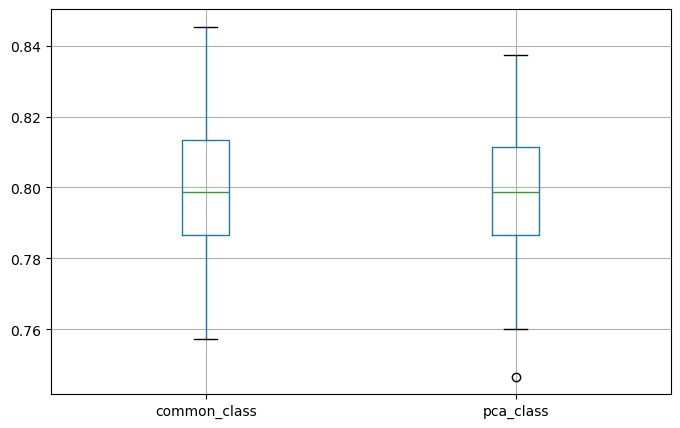

In [76]:
sdf=pd.DataFrame([ac1,ac2],index=['common_class','pca_class'])
sdf=sdf.T
sdf.boxplot(figsize=(8,5))

<Axes: >

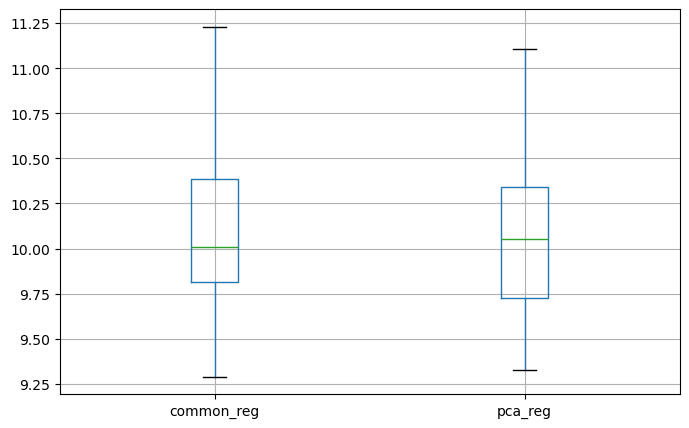

In [77]:
sdf2=pd.DataFrame([ac3,ac4],index=['common_reg','pca_reg'])
sdf2=sdf2.T
sdf2.boxplot(figsize=(8,5))

### Discussion
#### There was no statistical difference in model accuracy between random forest models derived from common texture metrics and models built using the newly described convolution PCA approach. However, the PCA methodology used 5 fewer predictor with the same accuracy. Moreover, the convolution PCA methodology provides an automated texture approach as opposed to using multiple convolution kernels and GLCMs.    